In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import pickle
from time_series_split import *

In [2]:
print(type(metrics))

<class 'module'>


In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
def calculate_aqi(pm25):
    ranges = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.0, 301, 500),
    ]
    for c_low, c_high, aqi_low, aqi_high in ranges:
        if c_low <= pm25 <= c_high:
            return round((aqi_high - aqi_low) / (c_high - c_low) * (pm25 - c_low) + aqi_low)
    return 500  # default nếu vượt ngưỡng

def aqi_class(aqi):
    if aqi <= 50: return 0
    elif aqi <= 100: return 1
    elif aqi <= 150: return 2
    elif aqi <= 200: return 3
    elif aqi <= 300: return 4
    else: return 5

In [5]:
combined_data = pd.read_csv('/home/thu/INT3041E_AI_PM2.5-Concentration-Estimation/data/add_AQI.csv')
combined_data.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,NDVI,CO,HCHO,NO2,SO2,CLOUD,O3,AAI,AQI,AQI_Class
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,...,0.000551,0.045586,0.000060,0.000072,0.000035,0.711612,0.101653,-0.836203,183,3
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,...,-0.003006,0.041913,0.000107,0.000086,0.000056,0.761720,0.103635,-0.718537,177,3
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,...,0.004388,0.042329,0.000108,0.000071,0.000026,0.867689,0.102144,-0.942304,183,3
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,...,-0.001733,0.041913,0.000097,0.000085,0.000079,0.779294,0.102875,-0.692613,183,3
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,...,0.016035,0.042298,0.000115,0.000082,-0.000345,0.705396,0.103488,-1.119681,162,3


In [6]:
# Tính cột AQI từ PM2.5
combined_data['AQI'] = combined_data['pm25'].apply(calculate_aqi)
# Gán nhãn lớp AQI
combined_data['AQI_Class'] = combined_data['AQI'].apply(aqi_class)

In [7]:
combined_data.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,NDVI,CO,HCHO,NO2,SO2,CLOUD,O3,AAI,AQI,AQI_Class
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,...,0.000551,0.045586,0.000060,0.000072,0.000035,0.711612,0.101653,-0.836203,183,3
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,...,-0.003006,0.041913,0.000107,0.000086,0.000056,0.761720,0.103635,-0.718537,177,3
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,...,0.004388,0.042329,0.000108,0.000071,0.000026,0.867689,0.102144,-0.942304,183,3
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,...,-0.001733,0.041913,0.000097,0.000085,0.000079,0.779294,0.102875,-0.692613,183,3
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,...,0.016035,0.042298,0.000115,0.000082,-0.000345,0.705396,0.103488,-1.119681,162,3


In [8]:
# folds = split_original_data()
folds = split_consolidated_data()
print(f"Number of folds: {len(folds)}")

Number of folds: 3


**Best paramters**

Sau khi tuning thì được Best parameters: {'n_estimators': 1200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}


Trước khi tuning:  acc = 0.28
Sau khi tuning: acc = 0.45

In [ ]:
params = {
    'n_estimators': 1200,
    'max_features': 'log2',
    'max_depth': 15,
    'min_samples_split': 15,
    'min_samples_leaf': 2
}


# Chưa tuning: acc = 0.28
# params = {
#     'n_estimators': 100,
#     'max_features': 'log2',
#     'max_depth': 5,
#     'min_samples_split': 10,
#     'min_samples_leaf': 10
# }

In [31]:
# Biến lưu nhãn thật và dự đoán trên toàn bộ test sets
all_y_true = []
all_y_pred = []

In [32]:
# Danh sách để lưu kết quả từ mỗi fold
val_accuracies = []
test_accuracies = []
test_classification_reports = []

best_val_accuracy = 0
best_model = None

In [33]:
all_target_names = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']


Processing Fold 1/3
Feature columns: Index(['lat', 'lon', 'SQRT_SEA_DEM_LAT', 'WSPD', 'WDIR', 'TMP', 'TX', 'TN',
       'TP', 'RH', 'PRES2M', 'NDVI', 'CO', 'HCHO', 'NO2', 'SO2', 'CLOUD', 'O3',
       'AAI'],
      dtype='object')
Train Accuracy: 0.6015 | Validation Accuracy: 0.4426 | Test Accuracy: 0.3394


/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


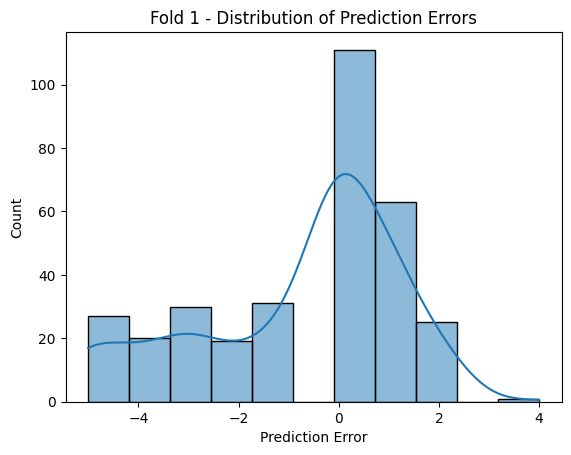


Processing Fold 2/3
Feature columns: Index(['lat', 'lon', 'SQRT_SEA_DEM_LAT', 'WSPD', 'WDIR', 'TMP', 'TX', 'TN',
       'TP', 'RH', 'PRES2M', 'NDVI', 'CO', 'HCHO', 'NO2', 'SO2', 'CLOUD', 'O3',
       'AAI'],
      dtype='object')
Train Accuracy: 0.5899 | Validation Accuracy: 0.2997 | Test Accuracy: 0.3366


/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


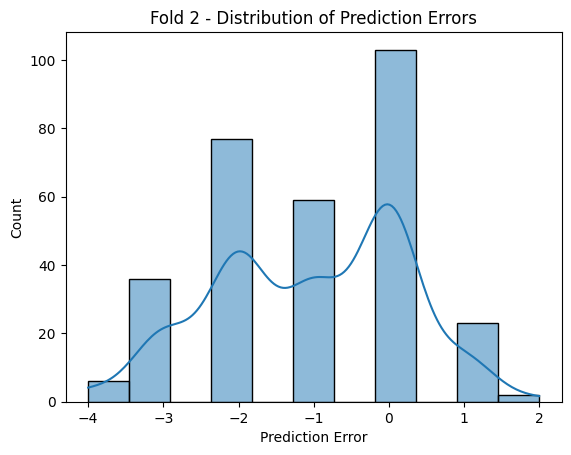


Processing Fold 3/3
Feature columns: Index(['lat', 'lon', 'SQRT_SEA_DEM_LAT', 'WSPD', 'WDIR', 'TMP', 'TX', 'TN',
       'TP', 'RH', 'PRES2M', 'NDVI', 'CO', 'HCHO', 'NO2', 'SO2', 'CLOUD', 'O3',
       'AAI'],
      dtype='object')
Train Accuracy: 0.5934 | Validation Accuracy: 0.3431 | Test Accuracy: 0.1899


/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3

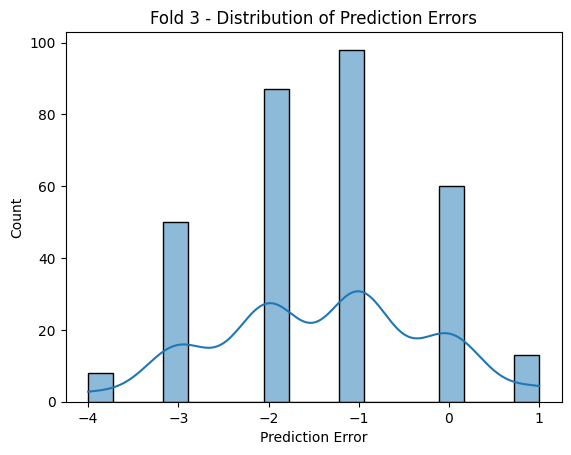

In [34]:
for i, fold in enumerate(folds):
    print(f"\nProcessing Fold {i+1}/{len(folds)}")

    train_data = fold['train']
    val_data = fold['validation']
    test_data = fold['test']

    feature_columns = train_data.columns[3:-2]
    print(f"Feature columns: {feature_columns}")
    # break
    X_train = train_data[feature_columns]
    y_train = train_data['AQI_Class']
    X_val = val_data[feature_columns]
    y_val = val_data['AQI_Class']
    X_test = test_data[feature_columns]
    y_test = test_data['AQI_Class']
    
    smote = SMOTE(random_state=42) 
    X_train, y_train = smote.fit_resample(X_train, y_train)

    clf = RandomForestClassifier(**params, random_state=43, class_weight='balanced')
    clf.fit(X_train, y_train)

    train_acc = clf.score(X_train, y_train)
    val_acc = clf.score(X_val, y_val)
    test_acc = clf.score(X_test, y_test)

    print(f"Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f} | Test Accuracy: {test_acc:.4f}")

    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model = clf

    y_pred = clf.predict(X_test)
    
    # Lưu nhãn thật và nhãn dự đoán để tính tổng sau này
    all_y_true.extend(y_test.tolist())
    all_y_pred.extend(y_pred.tolist())

    report = metrics.classification_report(y_test, y_pred, target_names=all_target_names, labels=[0,1,2,3,4,5], output_dict=True)
    test_classification_reports.append(report)

    # Biểu đồ sai số
    sns.histplot(y_test - y_pred, kde=True)
    plt.title(f'Fold {i+1} - Distribution of Prediction Errors')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.show()

In [35]:
mean_val_accuracy = np.mean(val_accuracies)
mean_test_accuracy = np.mean(test_accuracies)
print(f"\nAverage Validation Accuracy: {mean_val_accuracy:.4f}")
print(f"Average Test Accuracy: {mean_test_accuracy:.4f}")


Average Validation Accuracy: 0.3618
Average Test Accuracy: 0.2886


In [36]:
# Báo cáo trung bình từng lớp
avg_report = {}
for label in all_target_names:
    precisions = [r[label]['precision'] for r in test_classification_reports if label in r]
    recalls = [r[label]['recall'] for r in test_classification_reports if label in r]
    f1_scores = [r[label]['f1-score'] for r in test_classification_reports if label in r]
    supports = [r[label]['support'] for r in test_classification_reports if label in r]

    avg_report[label] = {
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1-score': np.mean(f1_scores),
        'support': sum(supports),
        'num_folds': len(precisions)
    }

# Weighted avg
avg_report['weighted avg'] = {
    'precision': np.mean([r['weighted avg']['precision'] for r in test_classification_reports]),
    'recall': np.mean([r['weighted avg']['recall'] for r in test_classification_reports]),
    'f1-score': np.mean([r['weighted avg']['f1-score'] for r in test_classification_reports]),
    'support': sum([r['weighted avg']['support'] for r in test_classification_reports])
}

In [37]:
# In ra report trung bình
print("\n📋 Average Classification Report:")
for label in sorted(avg_report.keys(), key=lambda x: x if x != 'weighted avg' else 'zzz'):
    print(f"{label}:")
    print(f"  Precision: {avg_report[label]['precision']:.4f}")
    print(f"  Recall: {avg_report[label]['recall']:.4f}")
    print(f"  F1-score: {avg_report[label]['f1-score']:.4f}")
    print(f"  Support: {avg_report[label]['support']:.0f}")
    if label != 'weighted avg':
        print(f"  Number of folds with this class: {avg_report[label]['num_folds']}")



📋 Average Classification Report:
Good:
  Precision: 0.5226
  Recall: 0.4187
  F1-score: 0.4649
  Support: 196
  Number of folds with this class: 3
Hazardous:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
  Support: 1
  Number of folds with this class: 3
Moderate:
  Precision: 0.3475
  Recall: 0.1448
  F1-score: 0.1892
  Support: 380
  Number of folds with this class: 3
Unhealthy:
  Precision: 0.3080
  Recall: 0.5344
  F1-score: 0.3840
  Support: 207
  Number of folds with this class: 3
Unhealthy for Sensitive:
  Precision: 0.1038
  Recall: 0.0708
  F1-score: 0.0836
  Support: 161
  Number of folds with this class: 3
Very Unhealthy:
  Precision: 0.0073
  Recall: 0.2500
  F1-score: 0.0142
  Support: 4
  Number of folds with this class: 3
weighted avg:
  Precision: 0.3541
  Recall: 0.2886
  F1-score: 0.2829
  Support: 949


In [38]:
# Tính và in classification report tổng tất cả sample
final_report = metrics.classification_report(
    all_y_true, all_y_pred,
    target_names=all_target_names,
    labels=[0, 1, 2, 3, 4, 5]
)

print("\n" + "="*60)
print("Overall Classification Report for ALL Samples")
print("="*60)
print(final_report)


Overall Classification Report for ALL Samples
                         precision    recall  f1-score   support

                   Good       0.58      0.46      0.51       196
               Moderate       0.46      0.14      0.22       380
Unhealthy for Sensitive       0.14      0.06      0.09       161
              Unhealthy       0.33      0.56      0.41       207
         Very Unhealthy       0.02      0.75      0.03         4
              Hazardous       0.00      0.00      0.00         1

               accuracy                           0.29       949
              macro avg       0.25      0.33      0.21       949
           weighted avg       0.40      0.29      0.30       949



In [39]:
# Báo cáo dạng dict để trích F1 tổng thể
report_dict = metrics.classification_report(
    all_y_true, all_y_pred,
    target_names=all_target_names,
    labels=[0,1,2,3,4,5],
    output_dict=True
)

overall_f1 = report_dict["weighted avg"]["f1-score"]
overall_support = report_dict["weighted avg"]["support"]
print(f"Weighted F1-score: {overall_f1:.4f} | Total Samples: {int(overall_support)}")


Weighted F1-score: 0.2989 | Total Samples: 949


In [40]:
# Lưu mô hình tốt nhất
pickle.dump(best_model, open('checkpoint/randomforest-aqi-classifier.pkl', 'wb'))
print("\nBest model saved as 'randomforest-aqi-classifier.pkl'")


Best model saved as 'randomforest-aqi-classifier.pkl'


In [41]:
# Thế muốn là phân lớp theo mức độ
 
# xem lại có chia fold không, có khả năng bị bias

# t đang chốt sẽ ensemble 3 : RF, XGB, calculate_aqi

# - chạy baseline 10 cái model khác
#   nếu có tốt hơn model đã chọn -> thì thay thế hoặc sẽ thêm vào để ensemble
  

# - Ưu tiên chạy xong data bọn mình đã tự đề xuất trước sau đó chạy thực nghiệm so sánh 2 bộ dữ liệu gốc + data nhóm đề xuất hiện => để chứng minh data đề xuất tốt hơn.


# do you know SMOTE :3
# SMOTE là phương pháp dùng khi bài toán phân lớp bị lệch á